<a href="https://colab.research.google.com/github/hwizard-wph/NAS/blob/main/Reinforce_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 27 kB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 3.8 MB 50.8 MB/s 
     |████████████████████████████████| 503 kB 27.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=aa7cefc4c326b8fc5e3d0c1ddfdab7a2bf8fcb5916480bfeb331adfcba44df9e
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [ ]:
!curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

from nasbench import api

nasbench = api.NASBench('nasbench_full.tfrecord')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1989M  100 1989M    0     0   168M      0  0:00:11  0:00:11 --:--:--  177M
Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (96/96), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py3-none-any.whl size=4678

In [ ]:
import numpy as np
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
OP_SPOTS = NUM_VERTICES - 2 
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]

In [ ]:
class Controller(nn.Module):
  def __init__(self, n_ops=3, n_nodes=5, hidden_size=64,  temperature=None,  tanh_constant=1.5, op_tanh_reduce=2.5, device="cpu"):
    super(Controller, self).__init__()
    self.n_ops = n_ops
    self.n_nodes = n_nodes
    self.hidden_size = hidden_size
    self.temperature = temperature
    self.tanh_constant = tanh_constant
    self.op_tanh_reduce = op_tanh_reduce

    self.n_nodes_embedding = nn.Embedding(n_nodes, self.hidden_size)
    self.node_embedding = nn.Embedding(n_nodes + 2, self.hidden_size)
    self.op_embedding = nn.Embedding(n_ops, self.hidden_size)

    self.lstm = nn.LSTMCell(self.hidden_size, self.hidden_size)
    self.emb_attn = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
    self.hid_attn = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
    self.v_attn = nn.Linear(self.hidden_size, 1, bias=False)
    self.w_soft = nn.Linear(self.hidden_size, self.n_ops)

    self.n_soft = nn.Linear(self.hidden_size, self.n_nodes)

    self.device = device
    self.batch_size = 1

    self.reset_parameters()

  def reset_parameters(self, init_range=0.1):
    for param in self.parameters():
      param.data.uniform_(-init_range, init_range)

  @functools.lru_cache(maxsize=128)
  def _zeros(self, batch_size):
    return torch.zeros((batch_size, self.hidden_size), device=self.device, requires_grad=False)

  def _scale_attention(self, logits, temperature, tanh_constant, constant_reduce=None):
    if temperature is not None:
      logits /= temperature
    if tanh_constant is not None:
      if constant_reduce is not None:
        tanh_constant /= constant_reduce
      logits = tanh_constant * torch.tanh(logits)
    return logits

  def _impl(self, probs):
    m = torch.distributions.Categorical(probs=probs)
    action = m.sample().view(-1)
    select_log_p = m.log_prob(action)
    entropy = m.entropy()
    return action, select_log_p, entropy

  def forward(self):
    arch_seq = []
    logp_buf = []
    entropy_buf = []

    inputs = self._zeros(self.batch_size)
    hidden = self._zeros(self.batch_size), self._zeros(self.batch_size)

    embed = inputs
    hx, cx = self.lstm(embed, hidden)
    hidden = (hx, cx)
    logits = self.n_soft(hx).view(-1)
    logits = self._scale_attention(logits, self.temperature, self.tanh_constant, self.op_tanh_reduce)
    probs = F.softmax(logits, dim=-1)
    action, select_log_p, entropy = self._impl(probs)

    arch_n_nodes = action.item() + 1 
    arch_seq.append(arch_n_nodes)
    logp_buf.append(select_log_p)
    entropy_buf.append(entropy)

    inputs = action
    embed = self.n_nodes_embedding(inputs)
    for node_idx in range(arch_n_nodes+1):
      hx, cx = self.lstm(embed, hidden)
      hidden = (hx, cx)
      query = self.node_embedding.weight[:node_idx+1, :]
      query = torch.tanh(self.emb_attn(query) + self.hid_attn(hx))
      logits = self.v_attn(query).view(-1)
      logits = self._scale_attention(logits, self.temperature, self.tanh_constant)
      probs = F.softmax(logits, dim=-1)
      action, select_log_p, entropy = self._impl(probs)
      arch_seq.append(action.item()) 
      logp_buf.append(select_log_p)
      entropy_buf.append(entropy)

      inputs = action
      embed = self.node_embedding(inputs)

      if node_idx == arch_n_nodes:
        break

      hx, cx = self.lstm(embed, hidden)
      hidden = (hx, cx)
      logits = self.w_soft(hx).view(-1)
      logits = self._scale_attention(logits, self.temperature, self.tanh_constant, self.op_tanh_reduce)
      probs = F.softmax(logits, dim=-1)
      action, select_log_p, entropy = self._impl(probs)
      arch_seq.append(action.item()) 
      logp_buf.append(select_log_p)
      entropy_buf.append(entropy)
      inputs = action
      embed = self.op_embedding(inputs)

    for i in range(2*(9-arch_n_nodes-1)):
      hx, cx = self.lstm(embed, hidden)
      hidden = (hx, cx)
      query = self.node_embedding.weight[:arch_n_nodes+2, :]
      query = torch.tanh(self.emb_attn(query) + self.hid_attn(hx))
      logits = self.v_attn(query).view(-1)
      logits = self._scale_attention(logits, self.temperature, self.tanh_constant)
      probs = F.softmax(logits, dim=-1)
      action, select_log_p, entropy = self._impl(probs)
      arch_seq.append(action.item()) 
      logp_buf.append(select_log_p)
      entropy_buf.append(entropy)

      inputs = action
      embed = self.node_embedding(inputs)

    return arch_seq, sum(logp_buf), sum(entropy_buf)

In [ ]:
def seq2arch(seq):
  n_nodes = seq[0]
  matrix = np.zeros(shape=(n_nodes+2, n_nodes+2), dtype=np.int32)
  ops = [INPUT]
  rev = seq[1:2*n_nodes+1]
  for to_node, (from_node, op_type) in enumerate(zip(rev[::2], rev[1::2]), start=1):
      matrix[from_node][to_node] = 1
      ops.append(ALLOWED_OPS[op_type])
  matrix[seq[2*n_nodes+1]][n_nodes+2-1] = 1
  rev = seq[2*n_nodes+2:]
  for (node0, node1) in zip(rev[::2], rev[1::2]):
      if node0 == node1:
          continue
      from_node = min(node0, node1)
      to_node = max(node0, node1)
      matrix[from_node][to_node] = 1
  ops.append(OUTPUT)
  spec = api.ModelSpec(matrix=matrix, ops=ops)
  return spec

In [ ]:
class ExponentialMovingAverage(object):
  """Class that maintains an exponential moving average."""

  def __init__(self, momentum):
    self._numerator = 0
    self._denominator = 0
    self._momentum = momentum

  def update(self, value):
    self._numerator = self._momentum * self._numerator + (1 - self._momentum) * value
    self._denominator = self._momentum * self._denominator + (1 - self._momentum)

  def value(self):
    """Return the current value of the moving average"""
    return self._numerator / self._denominator


In [ ]:
class ReinForce():
  def __init__(self):
    self.controller = Controller(3, 5, 64, None, 1.5, 2.5, "cuda").to(device = "cuda")
    self.optimizer = torch.optim.Adam(self.controller.parameters(), 0.025)
    self.eps = np.finfo(np.float32).eps.item()
    self.baseline = ExponentialMovingAverage(0.9)
  
  def get_reward(self):
    arch_seq, self.log_prob, self.entroy = self.controller()
    spec = seq2arch(arch_seq)
    if nasbench.is_valid(spec):
      data = nasbench.query(spec)
      return data['validation_accuracy'], data['test_accuracy']
    return 0, 0
  
  def optimize(self, reward=0):
    self.baseline.update(reward)
    # calculate loss
    policy_loss = (-self.log_prob * (reward - self.baseline.value())).sum()
    self.optimizer.zero_grad()
    policy_loss.backward()
    self.optimizer.step()

In [ ]:
def run(cycles):
  algo = ReinForce()
  trace = []
  for i in range(cycles):
    reward, test = algo.get_reward()
    algo.optimize(reward)
    trace.append((reward, test))
  best_test = max(trace, key=lambda x: x[0])[1]
  return best_test

Text(0.5, 0, '#Models Searched')

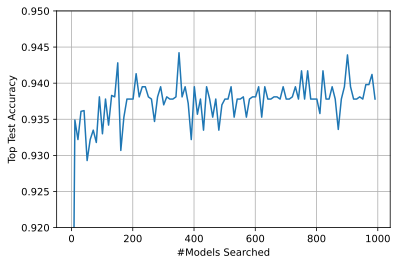

In [ ]:
xval = []
yval = []
for cycles in range(1, 1001, 10):
  xval.append(cycles)
  yval.append(run(cycles))
plt.plot(xval, yval)
plt.ylim(0.92, 0.95)
plt.grid()
plt.ylabel('Top Test Accuracy')
plt.xlabel('#Models Searched')